## 1. Pengambilan Sinyal Respirasi dengan **Mediapipe Pose**

MediaPipe adalah framework open-source yang dikembangkan oleh Google untuk pemrosesan multimedia dan visi komputer, terutama untuk aplikasi real-time seperti deteksi pose, wajah, tangan, objek, dan lain-lain. Sebelum melakukan percobaan, terlebih dahulu dilakukan pengambilan video dengan resolusi 1080 30fps dengan durasi ± 60 detik. Lalu, definisikan library yang akan digunakan.

In [20]:
import cv2
import mediapipe as mp
import numpy as np
from scipy.signal import butter, filtfilt, find_peaks
import matplotlib.pyplot as plt

Berikutnya adalah membuat filter `butterworth bandpass` dengan lowcut dan highcut berdasarkan frekuensi sampling (fs). Filter ini bertujuan untuk mempertahankan frekuensi pernafasan normal (biasanya dalam rentang 0.1-0.7 Hz).

In [21]:
# Fungsi untuk filter sinyal (Butterworth bandpass)
def butter_bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data)
    return y

Kemudian definisikan video yang akan digunakan untuk eksperimen. Proses ini juga akan mendapatkan fps untuk dilakukan filtering dan inisialisasi model Mediapipe Pose untuk mendeteksi landmark tubuh secara real-time.

In [24]:
# Baca video
video_path = 'dsp1menit.mp4'  # Ganti dengan path video Anda 
cap = cv2.VideoCapture(video_path)
fps = cap.get(cv2.CAP_PROP_FPS)

mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5)

Program kemudian akan membaca frame video satu per satu. OpenCV akan membaca video dengan format warna BGR (Blue, Green, Red) secara default, sementara Mediapipe membaca dan memproses format RGB. Oleh karena itu, digunakan fungsi `cv2.cvtColor` untuk mengubah format warna sehingga tidak akan terjadi salah interpretasi pada prosesnya. Program juga akan memproses frame untuk mendapatkan landmark pose. Landmark yang digunakan adalah pada titik 11 dan 12 yang merupakan bahu kanan dan kiri. Posisi vertikal dari landmark akan diambil dan hasil konversi format warna akan disimpan dalam bentuk array agar mudah diproses. Setelah proses selesai, program akan menutup video.

In [25]:
chest_y = []
frame_count = 0

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = pose.process(frame_rgb)
    if results.pose_landmarks:
        # Ambil titik dada (landmark 11 dan 12: left/right shoulder)
        left_shoulder = results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_SHOULDER]
        right_shoulder = results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_SHOULDER]
        chest_y.append((left_shoulder.y + right_shoulder.y) / 2)
    frame_count += 1

cap.release()
pose.close()

chest_y = np.array(chest_y)

Kemudian plot sinyal respirasi sebelum dilakukan post-processing.

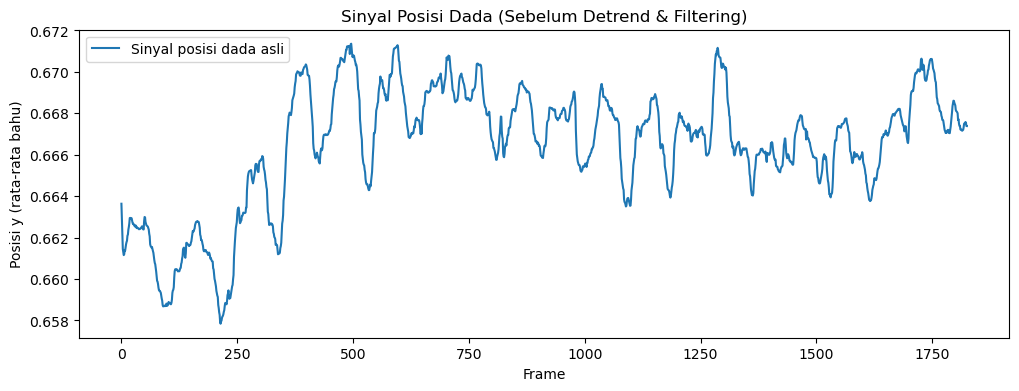

In [26]:
# Visualisasi sinyal posisi dada asli sebelum post-processing
plt.figure(figsize=(12,4))
plt.plot(chest_y, label='Sinyal posisi dada asli')
plt.title('Sinyal Posisi Dada (Sebelum Detrend & Filtering)')
plt.xlabel('Frame')
plt.ylabel('Posisi y (rata-rata bahu)')
plt.legend()
plt.show()

Berikutnya adalah post-processing. Lakukan detrending sinyal untuk menghilangkan trend. Trend pada sinyal adalah pergerakan umum naik atau turun yang berlangsung perlahan dan menutupi pola osilasi atau fluktuasi yang lebih kecil. Trend harus dihilangkan karena dapat mengganggu proses filtering dan deteksi puncak. Selain itu, dilakukan juga filtering sinyal dengan bandpass filter dan deteksi puncak sinyal sebagai indikasi awal siklus pernafasan.

In [27]:
# Hilangkan trend (detrend)
chest_y_detrended = chest_y - np.mean(chest_y)

# Filter sinyal (bandpass 0.1-0.7 Hz, laju nafas normal manusia)
filtered = butter_bandpass_filter(chest_y_detrended, 0.1, 0.7, fps)

# Temukan puncak (peak) sebagai siklus nafas
peaks, _ = find_peaks(filtered, distance=fps*1.5)  # Jarak antar peak minimal 1.5 detik

Kita lakukan plot untuk melihat sinyal setelah dilakukan post-processing.

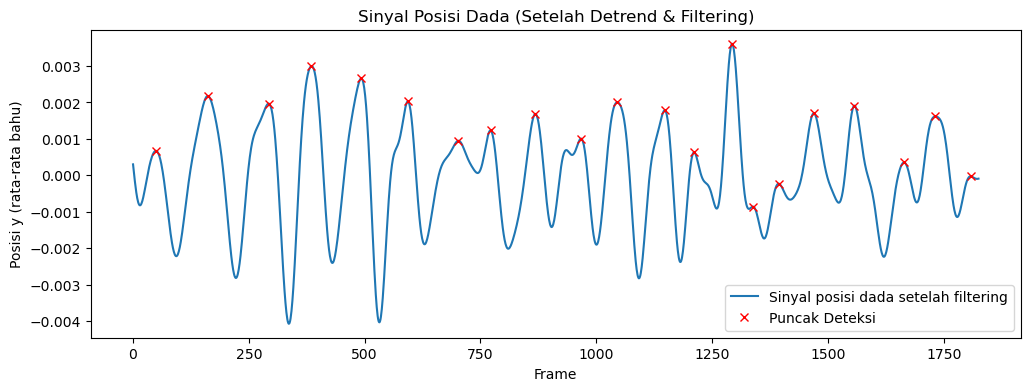

In [28]:
# Visualisasi sinyal posisi dada setelah post-processing
plt.figure(figsize=(12,4))
plt.plot(filtered, label='Sinyal posisi dada setelah filtering')
plt.plot(peaks, filtered[peaks], "rx", label='Puncak Deteksi')
plt.title('Sinyal Posisi Dada (Setelah Detrend & Filtering)')
plt.xlabel('Frame')
plt.ylabel('Posisi y (rata-rata bahu)')
plt.legend()
plt.show()

Berikutnya adalah mencari laju pernafasan (BPM) berdasarkan puncak dan durasi video dalam detik.

In [29]:
# Hitung laju pernafasan (breaths per minute)
duration_sec = len(chest_y) / fps
breaths_per_minute = len(peaks) / duration_sec * 60

Diperoleh hasil laju pernafasan adalah 20.70 BPM. Diketahui bahwa nilai normal laju pernafasan orang dewasa (18 tahun ke atas) saat istirahat adalah sekitar 12-20 BPM. Hasil 20.70 BPM menunjukkan bahwa objek dalam video memiliki laju pernafasan **normal** walau nilainya berada sedikit di atas rentang normal. Hal tersebut mungkin dipengaruhi oleh kualitas video atau kondisi objek saat dilakukan pengambilan video (gugup, dll).

In [78]:
duration_sec_flow = len(chest_y) / fps

print(f"Jumlah puncak: {len(peaks)}")
print(f"Durasi sinyal (detik): {duration_sec_flow:.2f}")

print(f"Laju pernafasan (Mediapipe): {breaths_per_minute:.2f} breaths per minute")

Jumlah puncak: 21
Durasi sinyal (detik): 60.87
Laju pernafasan (Mediapipe): 20.70 breaths per minute


## 2. Pengambilan Sinyal Respirasi dengan **Lucas-Kanade Optical Flow**

Optical flow adalah pola pergerakan piksel atau intensitas cahaya antar dua frame gambar berurutan dalam video. Dengan kata lain, ini adalah cara untuk menghitung arah dan kecepatan gerakan objek atau permukaan dalam citra berdasarkan perubahan intensitas dari satu frame ke frame berikutnya.

Metode Lucas-Kanade adalah salah satu teknik klasik untuk menghitung optical flow yang dikembangkan oleh Bruce D. Lucas dan Takeo Kanade pada tahun 1981. Metode ini berasumsi bahwa intensitas cahaya piksel tidak berubah secara signifikan antara dua frame berturut-turut meskipun posisi piksel berubah (brightness constancy assumption). Tujuannya adalah menemukan vektor perpindahan `(u, v)` di bidang gambar/video yang menunjukkan perpindahan posisi piksel antara frame pertama dan kedua.

Proses pengambilan sinyal respirasi dilakukan dengan video yang sama dengan sebelumnya. Mula-mula definisikan library yang akan digunakan.

In [87]:
import cv2
import numpy as np
from scipy.signal import butter, filtfilt, find_peaks
import matplotlib.pyplot as plt

Di sini juga digunakan filter `butterworth bandpass` yang sama dengan metode sebelumnya.

In [88]:
# Fungsi filter Butterworth bandpass (sama seperti sebelumnya)
def butter_bandpass_filter(data, lowcut, highcut, fs, order=4):
    from scipy.signal import butter, filtfilt
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data)
    return y

Kemudian program akan membuka video dan mendapatkan fps (frame per detik) untuk parameter filtering dan penghitungan waktu.

In [89]:
video_path = 'dsp1menit.mp4'

# --- Pengambilan Sinyal Respirasi dengan Lucas-Kanade Optical Flow ---
cap = cv2.VideoCapture(video_path)

# Definisi fps setelah membuka video ulang
fps = cap.get(cv2.CAP_PROP_FPS)

Berikutnya, atur paramater Lucas-Kanade, dimana:
- `winSize`: ukuran jendela pencarian pergerakan.
- `maxLevel`: jumlah level pyramid untuk skala (multi resolusi).
- `criteria`: kondisi penghentian iterasi algoritma.

In [90]:
lk_params = dict(winSize=(15, 15), maxLevel=2,
         criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

Program lalu akan mengambil frame pertama dan mengonversi ke format grayscale karena metode Lucas-Kanade bekerja dalam format grayscale.

In [91]:
ret, first_frame = cap.read()
if not ret:
    raise RuntimeError("Tidak bisa membaca frame pertama video.")
first_gray = cv2.cvtColor(first_frame, cv2.COLOR_BGR2GRAY)
h, w = first_gray.shape

Lalu, tentukan area fokus ROI pada frame pertama sebagai referensi. ROI akan berada di 30% dari lebar frame mulai dari kiri, 43% dari tinggi frame mulai dari atas. Luas ROI sekitar 40% lebar dan 20% tinggi frame. 

In [92]:
roi_x = int(w * 0.3)
roi_y = int(h * 0.43)
roi_w = int(w * 0.4)
roi_h = int(h * 0.2)
roi = first_gray[roi_y:roi_y+roi_h, roi_x:roi_x+roi_w]

Berikut adalah ROI pada frame pertama.

<img src="ROI.png" alt="roi" width="700" />

Kemudian program akan mendeteksi titik-titik kuat yang dapat dilacak dengan Lucas-Kanade di dalam ROI.

In [93]:
p0 = cv2.goodFeaturesToTrack(roi, mask=None, maxCorners=50, qualityLevel=0.01, minDistance=7, blockSize=7)
if p0 is not None:
    p0[:, 0, 0] += roi_x
    p0[:, 0, 1] += roi_y
else:
    raise RuntimeError("Tidak ditemukan fitur pada ROI.")

Kemudian buat sebuah variabel `flow_y` yang akan menyimpan posisi vertikal rata-rata titik fitur dari setiap frame (menandakan gerakan naik-turun). Serta variabel `prev_gray` dan `prev_pts` untuk menyimpan frame dan titik fitur sebelumnya sebagai referensi.

In [94]:
flow_y = []

prev_gray = first_gray.copy()
prev_pts = p0.copy()

Kemudian akan dilakukan looping untuk membaca frame. Untuk setiap frame akan dilakukan konversi ke format grayscale, menghitung optical flow titik fitur dari frame sebelumnya ke frame sekarang, mengambil rata-rata dari posisi vertikal dan simpan di variabel `flow_y`, mengupdate titik fitur dan frame sebelumnya untuk iterasi berikutnya, dan mengulang nilai terakhir apabila tracking gagal. Hasil dari proses akan dikonversi menjadi array numpy.

In [95]:
while True:
    ret, frame = cap.read()
    if not ret:
        break
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    p1, st, err = cv2.calcOpticalFlowPyrLK(prev_gray, frame_gray, prev_pts, None, **lk_params)
    if p1 is not None and st.sum() > 0:
        good_new = p1[st == 1]
        mean_y = np.mean(good_new[:, 1])
        flow_y.append(mean_y)
        prev_pts = good_new.reshape(-1, 1, 2)
    else:
        flow_y.append(flow_y[-1] if flow_y else 0)
    prev_gray = frame_gray.copy()

cap.release()

flow_y = np.array(flow_y)

Lakukan visualisasi sinyal sebelum dilakukan post-processing.

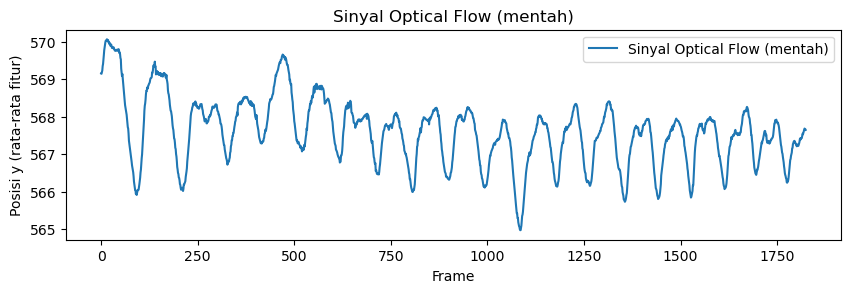

In [96]:
#visualisasi sinyal sebelum post-processing
plt.figure(figsize=(10,6))
plt.subplot(2, 1, 1)
plt.plot(flow_y, label='Sinyal Optical Flow (mentah)')
plt.title('Sinyal Optical Flow (mentah)')
plt.xlabel('Frame')
plt.ylabel('Posisi y (rata-rata fitur)')
plt.legend()

Kemudian lakukan post-processing. Hilangkan trend agar sinyal berosilasi di sekitar nol, dan filtering dengan bandpass untuk rentang pernafasan normal.

In [97]:
# Post-processing
flow_y_detrended = flow_y - np.mean(flow_y)
flow_filtered = butter_bandpass_filter(flow_y_detrended, 0.1, 0.7, fps)

Temukan puncak (peak) sebagai siklus nafas, hitung durasi video, dan hitung laju pernafasan dalam BPM.

In [100]:
peaks_flow, _ = find_peaks(flow_filtered, distance=fps*1.5)
duration_sec_flow = len(flow_y) / fps
bpm_flow = len(peaks_flow) / duration_sec_flow * 60

Lakukan visualisasi untuk sinyal setelah dilakukan post-processing.

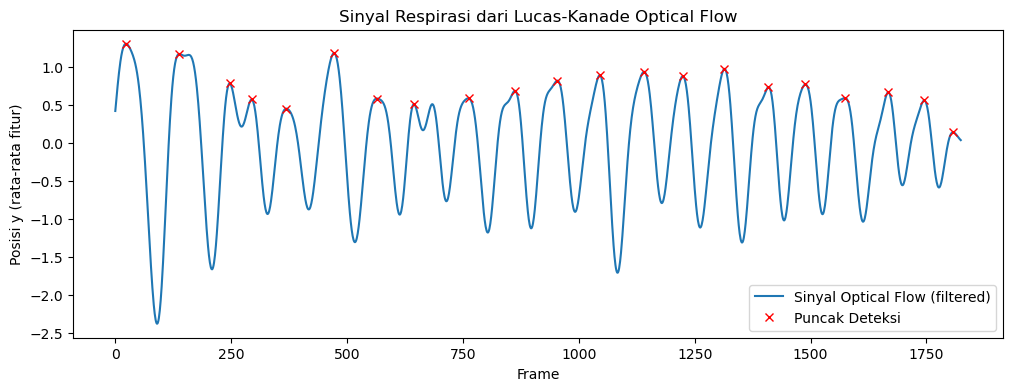

In [101]:
plt.figure(figsize=(12,4))
plt.plot(flow_filtered, label='Sinyal Optical Flow (filtered)')
plt.plot(peaks_flow, flow_filtered[peaks_flow], "rx", label='Puncak Deteksi')
plt.title('Sinyal Respirasi dari Lucas-Kanade Optical Flow')
plt.xlabel('Frame')
plt.ylabel('Posisi y (rata-rata fitur)')
plt.legend()
plt.show()

Diperoleh hasil laju pernafasan adalah 20.71 BPM. Hasil 20.71 BPM menunjukkan bahwa objek dalam video memiliki laju pernafasan **normal** walau nilainya berada sedikit di atas rentang normal.

In [102]:
duration_sec_flow = len(flow_y) / fps

print(f"Jumlah puncak: {len(peaks_flow)}")
print(f"Durasi sinyal (detik): {duration_sec_flow:.2f}")
print(f"Laju pernafasan (Lucas-Kanade Optical Flow): {bpm_flow:.2f} breaths per minute")

Jumlah puncak: 21
Durasi sinyal (detik): 60.83
Laju pernafasan (Lucas-Kanade Optical Flow): 20.71 breaths per minute


## Perbandingan Data Kedua Metode

Berikut adalah tabel data hasil pencatatan pernafasan yang dihitung dengan stopwatch pada HP ketika proses pengambilan video. Video diambil selama ± 60 detik. Diperoleh sekitar 20 BPM melalui pengukuran dengan stopwatch.

| Nafas-ke | Second | Milisecond |
|----------|--------|------------|
|    1     |   4    |     13     |
|    2     |   8    |     27     |
|    3     |  11    |     84     |
|    4     |  15    |     15     |
|    5     |  18    |     54     |
|    6     |  21    |     52     |
|    7     |  24    |     69     |
|    8     |  27    |     83     |
|    9     |  31    |     11     |
|   10     |  34    |     13     |
|   11     |  37    |     00     |
|   12     |  40    |     21     |
|   13     |  43    |     32     |
|   14     |  46    |     19     |
|   15     |  48    |     90     |
|   16     |  51    |     73     |
|   17     |  54    |     69     |
|   18     |  57    |     36     |
|   19     |  60    |     40     |
|   20     |  61    |     88     |


Kemudian kita bandingkan hasil laju pernafasan (BPM) yang diperoleh dengan kedua metode seperti berikut ini. Durasi sinyal yang diproses oleh kedua metode sedikit berbeda, sehingga BPM yang diperoleh juga sedikit berbeda. Pada metode Mediapipe Pose diperoleh sekitar 20.70 BPM, sementara pada metode Lucas-Kanade diperoleh sekitar 20.71 BPM.

| Metode         | Jumlah puncak | Durasi sinyal | BPM   |
|----------------|----------------|----------------|--------|
| Mediapipe      | 21             | 60.87          | 20.70 |
| Lucas-Kanade   | 21             | 60.83          | 20.71 |

Jumlah BPM yang diperoleh dengan kedua metode ini juga mengalami sedikit perbedaan dengan pengukuran menggunakan stopwatch, yaitu sekitar 20 BPM.

<div style="text-align: justify;">

**Kesimpulan**

Berdasarkan seluruh percobaan yang telah dilakukan, diperoleh bahwa kedua metode ekstraksi laju pernafasan dari video, yaitu menggunakan Mediapipe Pose dan Lucas-Kanade Optical Flow, menghasilkan estimasi laju pernafasan yang sangat mirip, yaitu sekitar 20.70 BPM (Mediapipe) dan 20.71 BPM (Lucas-Kanade). Nilai ini juga sangat dekat dengan hasil pengukuran manual menggunakan stopwatch (sekitar 20 BPM). Hal ini menunjukkan bahwa kedua metode dapat digunakan untuk memantau laju pernafasan secara non-invasif dari video dengan tingkat akurasi yang baik. Perbedaan kecil yang muncul kemungkinan disebabkan oleh perbedaan durasi sinyal yang terdeteksi, kualitas video, serta sensitivitas masing-masing metode terhadap noise dan artefak gerakan. Secara keseluruhan, baik metode Mediapipe maupun Lucas-Kanade Optical Flow dapat diandalkan untuk aplikasi pemantauan laju pernafasan berbasis video.

</div>

## Referensi

<a href="https://chatgpt.com/share/e/68286664-ff18-8002-a0ee-fb640e6757de" target="blank">Link Referensi</a>

In [ ]:
# Ringkasan Eksperimen
print("Ringkasan Eksperimen:")
print("""
1. Dua metode digunakan untuk mengekstraksi laju pernafasan dari video: Mediapipe Pose (deteksi landmark bahu) dan Lucas-Kanade Optical Flow (pelacakan fitur pada ROI dada).
2. Kedua metode memproses video yang sama, melakukan filtering sinyal dengan Butterworth bandpass, dan mendeteksi puncak sebagai siklus nafas.
3. Hasil laju pernafasan yang diperoleh sangat mirip: sekitar 20.70 BPM (Mediapipe) dan 20.71 BPM (Lucas-Kanade), sesuai dengan pengukuran manual (sekitar 20 BPM).
4. Kedua metode terbukti efektif dan akurat untuk pemantauan laju pernafasan berbasis video secara non-invasif.
""")

In [3]:
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Hanya tampilkan error, sembunyikan info & warning TensorFlow
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

In [8]:
import cv2
import mediapipe as mp
import numpy as np
from scipy.signal import butter, filtfilt, find_peaks
from collections import deque

import matplotlib.pyplot as plt

# --- Parameter ---
fs = 30  # asumsi fps webcam
buffer_size = fs * 10  # buffer 10 detik

# --- Buffer untuk sinyal ---
chest_y_buffer = deque(maxlen=buffer_size)
face_g_buffer = deque(maxlen=buffer_size)

# --- Inisialisasi Mediapipe ---
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5)
mp_face = mp.solutions.face_detection
face_detection = mp_face.FaceDetection(min_detection_confidence=0.5)

# --- Webcam ---
cap = cv2.VideoCapture(1)

def butter_bandpass_filter(data, lowcut, highcut, fs, order=4):
  nyq = 0.5 * fs
  low = lowcut / nyq
  high = highcut / nyq
  b, a = butter(order, [low, high], btype='band')
  y = filtfilt(b, a, data)
  return y

while True:
  ret, frame = cap.read()
  if not ret:
    break
  frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
  # --- Respirasi (Pose) ---
  results = pose.process(frame_rgb)
  if results.pose_landmarks:
    left_shoulder = results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_SHOULDER]
    right_shoulder = results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_SHOULDER]
    chest_y = (left_shoulder.y + right_shoulder.y) / 2
    chest_y_buffer.append(chest_y)
  # --- rPPG (Face ROI) ---
  face_results = face_detection.process(frame_rgb)
  if face_results.detections:
    bboxC = face_results.detections[0].location_data.relative_bounding_box
    ih, iw, _ = frame.shape
    x1 = int(bboxC.xmin * iw)
    y1 = int(bboxC.ymin * ih)
    x2 = int((bboxC.xmin + bboxC.width) * iw)
    y2 = int((bboxC.ymin + bboxC.height) * ih)
    face_roi = frame_rgb[max(0, y1):y2, max(0, x1):x2]
    if face_roi.size > 0:
      mean_g = np.mean(face_roi[:, :, 1])
      face_g_buffer.append(mean_g)
  # --- Visualisasi sederhana ---
  cv2.imshow('Webcam', frame)
  if cv2.waitKey(1) & 0xFF == 27:
    break

cap.release()
cv2.destroyAllWindows()
pose.close()
face_detection.close()

# --- Analisis sinyal setelah buffer terisi ---
if len(chest_y_buffer) > fs * 5 and len(face_g_buffer) > fs * 5:
  # Respirasi
  chest_y_arr = np.array(chest_y_buffer)
  chest_y_detrended = chest_y_arr - np.mean(chest_y_arr)
  filtered_resp = butter_bandpass_filter(chest_y_detrended, 0.1, 0.7, fs)
  peaks_resp, _ = find_peaks(filtered_resp, distance=fs*1.5)
  bpm_resp = len(peaks_resp) / (len(filtered_resp)/fs) * 60

  # rPPG
  face_g_arr = np.array(face_g_buffer)
  face_g_detrended = face_g_arr - np.mean(face_g_arr)
  filtered_ppg = butter_bandpass_filter(face_g_detrended, 0.7, 3.0, fs)
  peaks_ppg, _ = find_peaks(filtered_ppg, distance=fs*0.5)
  bpm_ppg = len(peaks_ppg) / (len(filtered_ppg)/fs) * 60

  print(f"Laju pernafasan (BPM): {bpm_resp:.2f}")
  print(f"Detak jantung (rPPG, BPM): {bpm_ppg:.2f}")

  # Plot
  plt.figure(figsize=(12,5))
  plt.subplot(2,1,1)
  plt.plot(filtered_resp, label='Respirasi (filtered)')
  plt.plot(peaks_resp, filtered_resp[peaks_resp], "rx")
  plt.legend()
  plt.subplot(2,1,2)
  plt.plot(filtered_ppg, label='rPPG (filtered)')
  plt.plot(peaks_ppg, filtered_ppg[peaks_ppg], "rx")
  plt.legend()
  plt.show()

error: OpenCV(4.11.0) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window.cpp:1295: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvDestroyAllWindows'


In [12]:
import cv2
import mediapipe as mp
import numpy as np
from scipy.signal import butter, filtfilt, find_peaks
from collections import deque

import matplotlib.pyplot as plt

# --- Parameter ---
fs = 30  # asumsi fps webcam
buffer_size = fs * 10  # buffer 10 detik

# --- Buffer untuk sinyal ---
chest_y_buffer = deque(maxlen=buffer_size)
face_g_buffer = deque(maxlen=buffer_size)

# --- Inisialisasi Mediapipe ---
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5)
mp_face = mp.solutions.face_detection
face_detection = mp_face.FaceDetection(min_detection_confidence=0.5)

# --- Webcam ---
cap = cv2.VideoCapture(1)

def butter_bandpass_filter(data, lowcut, highcut, fs, order=4):
  nyq = 0.5 * fs
  low = lowcut / nyq
  high = highcut / nyq
  b, a = butter(order, [low, high], btype='band')
  y = filtfilt(b, a, data)
  return y

while True:
  ret, frame = cap.read()
  if not ret:
    break
  frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
  # --- Respirasi (Pose) ---
  results = pose.process(frame_rgb)
  if results.pose_landmarks:
    left_shoulder = results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_SHOULDER]
    right_shoulder = results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_SHOULDER]
    chest_y = (left_shoulder.y + right_shoulder.y) / 2
    chest_y_buffer.append(chest_y)
  # --- rPPG (Face ROI) ---
  face_results = face_detection.process(frame_rgb)
  if face_results.detections:
    bboxC = face_results.detections[0].location_data.relative_bounding_box
    ih, iw, _ = frame.shape
    x1 = int(bboxC.xmin * iw)
    y1 = int(bboxC.ymin * ih)
    x2 = int((bboxC.xmin + bboxC.width) * iw)
    y2 = int((bboxC.ymin + bboxC.height) * ih)
    face_roi = frame_rgb[max(0, y1):y2, max(0, x1):x2]
    if face_roi.size > 0:
      mean_g = np.mean(face_roi[:, :, 1])
      face_g_buffer.append(mean_g)
  # --- Visualisasi sederhana ---
  cv2.imshow('Webcam', frame)
  if cv2.waitKey(1) & 0xFF == 27:
    break

cap.release()

# Safely close OpenCV windows if supported
try:
  cv2.destroyAllWindows()
except Exception as e:
  print("cv2.destroyAllWindows() is not supported in this environment.")
  
pose.close()
face_detection.close()

# --- Analisis sinyal setelah buffer terisi ---
if len(chest_y_buffer) > fs * 5 and len(face_g_buffer) > fs * 5:
  # Respirasi
  chest_y_arr = np.array(chest_y_buffer)
  chest_y_detrended = chest_y_arr - np.mean(chest_y_arr)
  filtered_resp = butter_bandpass_filter(chest_y_detrended, 0.1, 0.7, fs)
  peaks_resp, _ = find_peaks(filtered_resp, distance=fs*1.5)
  bpm_resp = len(peaks_resp) / (len(filtered_resp)/fs) * 60

  # rPPG
  face_g_arr = np.array(face_g_buffer)
  face_g_detrended = face_g_arr - np.mean(face_g_arr)
  filtered_ppg = butter_bandpass_filter(face_g_detrended, 0.7, 3.0, fs)
  peaks_ppg, _ = find_peaks(filtered_ppg, distance=fs*0.5)
  bpm_ppg = len(peaks_ppg) / (len(filtered_ppg)/fs) * 60

  print(f"Laju pernafasan (BPM): {bpm_resp:.2f}")
  print(f"Detak jantung (rPPG, BPM): {bpm_ppg:.2f}")

  # Plot
  plt.figure(figsize=(12,5))
  plt.subplot(2,1,1)
  plt.plot(filtered_resp, label='Respirasi (filtered)')
  plt.plot(peaks_resp, filtered_resp[peaks_resp], "rx")
  plt.legend()
  plt.subplot(2,1,2)
  plt.plot(filtered_ppg, label='rPPG (filtered)')
  plt.plot(peaks_ppg, filtered_ppg[peaks_ppg], "rx")
  plt.legend()
  plt.show()

cv2.destroyAllWindows() is not supported in this environment.


In [ ]:
# Safely close OpenCV windows if supported
try:
  cv2.destroyAllWindows()
except Exception as e:
  print("cv2.destroyAllWindows() is not supported in this environment.")